<a href="https://colab.research.google.com/github/u0sama/Pyfolio-in-Backtrader/blob/main/PyfolioBt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip uninstall pandas


Found existing installation: pandas 1.3.5
Uninstalling pandas-1.3.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.3.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.3.5


In [1]:
%pip install pymc3
%pip install --upgrade pymc3
%pip install git+https://github.com/quantopian/pyfolio

%pip install backtesting
%pip install investpy
%pip install backtrader[plotting]
%pip install backtrader
%pip install pandas

%pip install --upgrade pandas
%pip install --upgrade pandas-datareader
%pip install yfinance --upgrade --no-cache-dir
%pip install mplfinance
%pip install pandas --upgrade

%pip install yahoofinancials

import yfinance as yf
import mplfinance as mpf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover

import investpy


import os
import backtrader as bt
import backtrader.indicators as btind
import datetime as dt
import pandas as pd
import pandas_datareader as web
from pandas import Series, DataFrame
import random
from copy import deepcopy
from pandas_datareader import data as pdr
from yahoofinancials import YahooFinancials






  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-4j00irh9
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-4j00irh9


/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [2]:
class SMAC(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"fast": 20, "slow": 50,                  # The windows for both fast and slow moving averages
              "optim": False, "optim_fs": (20, 50)}    # Used for optimization; equivalent of fast and slow, but a tuple
                                                       # The first number in the tuple is the fast MA's window, the
                                                       # second the slow MA's window
 
    def __init__(self):
        """Initialize the strategy"""

        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
 
        if self.params.optim:    # Use a tuple during optimization
            self.params.fast, self.params.slow = self.params.optim_fs    # fast and slow replaced by tuple's contents
 
        if self.params.fast > self.params.slow:
            raise ValueError(
                "A SMAC strategy cannot have the fast moving average's window be " + \
                 "greater than the slow moving average window.")
 
        for d in self.getdatanames():
 
            # The moving averages
            self.fastma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.fast,    # Fast moving average
                                                       plotname="FastMA: " + d)
            self.slowma[d] = btind.SimpleMovingAverage(self.getdatabyname(d),      # The symbol for the moving average
                                                       period=self.params.slow,    # Slow moving average
                                                       plotname="SlowMA: " + d)
 
            # Get the regime
            self.regime[d] = self.fastma[d] - self.slowma[d]    # Positive when bullish
 
    def next(self):
        """Define what will be done in a single step, including creating and closing trades"""
        for d in self.getdatanames():    # Looping through all symbols
            pos = self.getpositionbyname(d).size or 0
            if pos == 0:    # Are we out of the market?
                # Consider the possibility of entrance
                # Notice the indexing; [0] always mens the present bar, and [-1] the bar immediately preceding
                # Thus, the condition below translates to: "If today the regime is bullish (greater than
                # 0) and yesterday the regime was not bullish"
                if self.regime[d][0] > 0 and self.regime[d][-1] <= 0:    # A buy signal
                    self.buy(data=self.getdatabyname(d))
 
            else:    # We have an open position
                if self.regime[d][0] <= 0 and self.regime[d][-1] > 0:    # A sell signal
                    self.sell(data=self.getdatabyname(d))
 
     
class PropSizer(bt.Sizer):
    """A position sizer that will buy as many stocks as necessary for a certain proportion of the portfolio
       to be committed to the position, while allowing stocks to be bought in batches (say, 100)"""
    params = {"prop": 0.1, "batch": 100}
 
    def _getsizing(self, comminfo, cash, data, isbuy):
        """Returns the proper sizing"""
 
        if isbuy:    # Buying
            target = self.broker.getvalue() * self.params.prop    # Ideal total value of the position
            price = data.close[0]
            shares_ideal = target / price    # How many shares are needed to get target
            batches = int(shares_ideal / self.params.batch)    # How many batches is this trade?
            shares = batches * self.params.batch    # The actual number of shares bought
 
            if shares * price > cash:
                return 0    # Not enough money for this trade
            else:
                return shares
 
        else:    # Selling
            return self.broker.getposition(data).size    # Clear the position
 
 
class AcctValue(bt.Observer):
    alias = ('Value',)
    lines = ('value',)
 
    plotinfo = {"plot": True, "subplot": True}
 
    def next(self):
        self.lines.value[0] = self._owner.broker.getvalue()    # Get today's account value (cash + stocks)
 
 
class AcctStats(bt.Analyzer):
    """A simple analyzer that gets the gain in the value of the account; should be self-explanatory"""
 
    def __init__(self):
        self.start_val = self.strategy.broker.get_value()
        self.end_val = None
 
    def stop(self):
        self.end_val = self.strategy.broker.get_value()
 
    def get_analysis(self):
        return {"start": self.start_val, "end": self.end_val,
                "growth": self.end_val - self.start_val, "return": self.end_val / self.start_val}

In [10]:

# Data from investing
symbols = ["USD/JPY"]
datafeeds = {s:investpy.get_currency_cross_historical_data(currency_cross= s ,as_json=False, from_date='01/01/2016', to_date='21/12/2021')for s in symbols}

datafeeds

{'USD/JPY':               Open    High     Low   Close Currency
 Date                                               
 2016-01-01  120.27  120.33  120.27  120.33      JPY
 2016-01-04  120.27  120.47  118.68  119.44      JPY
 2016-01-05  119.41  119.71  118.77  119.06      JPY
 2016-01-06  119.05  119.17  118.22  118.47      JPY
 2016-01-07  118.46  118.77  117.30  117.68      JPY
 ...            ...     ...     ...     ...      ...
 2021-12-15  113.72  114.28  113.62  114.02      JPY
 2021-12-16  114.03  114.25  113.56  113.70      JPY
 2021-12-17  113.65  113.86  113.14  113.67      JPY
 2021-12-20  113.63  113.74  113.32  113.58      JPY
 2021-12-21  113.60  114.23  113.55  114.08      JPY
 
 [1558 rows x 5 columns]}

<IPython.core.display.Javascript object>

[[<Figure size 1152x864 with 2 Axes>]]

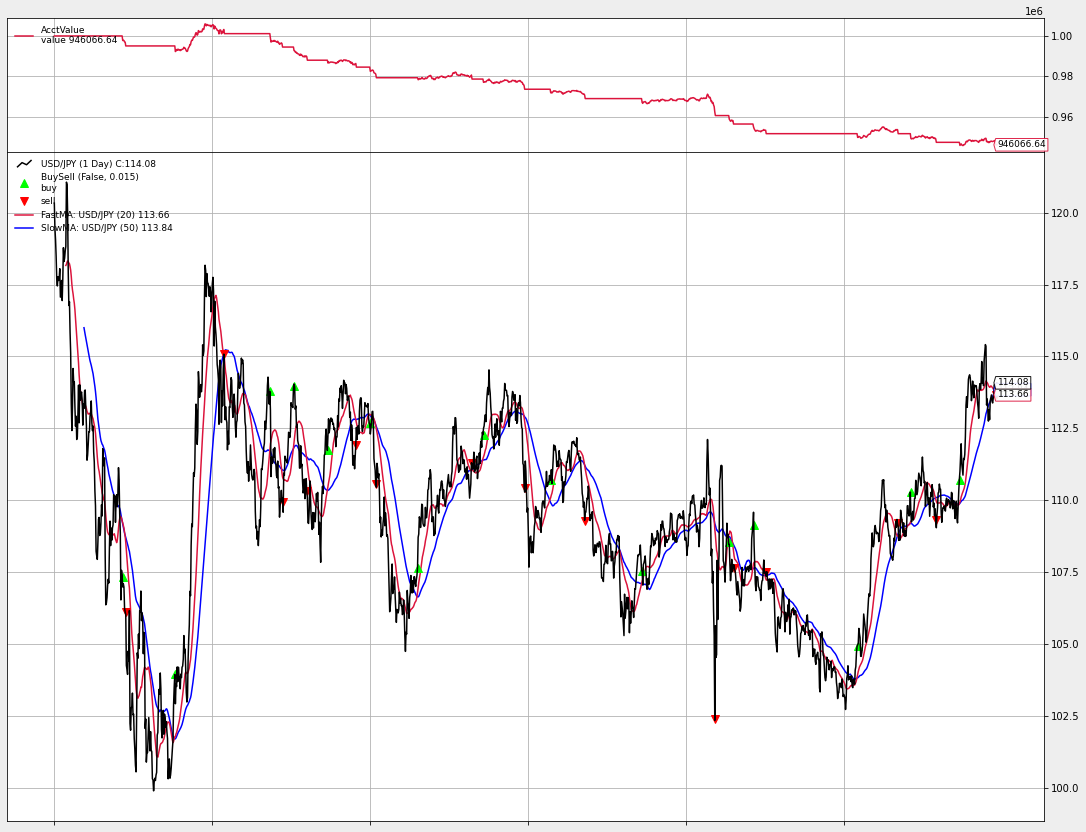

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16,12
rcParams['figure.facecolor'] = '#eeeeee'
plt.title('dummy')
plt.plot([1,3,2,4])
plt.close()

for df in datafeeds.values():
    df["OpenInterest"] = 0    # PandasData reader expects an OpenInterest column;
                              # not provided by Google and we don't use it so set to 0
cerebro = bt.Cerebro(stdstats=False)
 
plot_symbols = ["USD/JPY"]
is_first = True
#plot_symbols = []
for s, df in datafeeds.items():
    data = bt.feeds.PandasData(dataname=df, name=s)
    if s in plot_symbols:
        if is_first:
            data_main_plot = data
            is_first = False
        else:
            data.plotinfo.plotmaster = data_main_plot
    else:
        data.plotinfo.plot = False
    cerebro.adddata(data)    # Give the data to cerebro
 
cerebro.broker.setcash(1000000)
cerebro.broker.setcommission(0.02)
cerebro.addstrategy(SMAC)
cerebro.addobserver(AcctValue)
cerebro.addobservermulti(bt.observers.BuySell)    # Plots up/down arrows
cerebro.addsizer(PropSizer)
cerebro.addanalyzer(AcctStats)
 
cerebro.run()
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
 
stats = cerebro.run()


#from google.colab import files
#from IPython.display import Image
#chart_file = 'result.png'
cerebro.plot(iplot=True, volume=False, style= 'lines')
#Image(open(chart_file, 'rb').read())

Start date,2016-01-01
End date,2021-12-21
Total months,74
,Backtest
Annual return,-0.893%
Cumulative returns,-5.393%
Annual volatility,0.625%
Sharpe ratio,-1.43
Calmar ratio,-0.15
Stability,0.96
Max drawdown,-5.997%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.00,2016-12-15,2021-10-04,NaT,NaN
1,0.77,2016-06-07,2016-10-07,2016-11-23,122
2,0.13,2016-11-24,2016-11-28,2016-11-30,5
3,0.08,2016-11-30,2016-12-02,2016-12-09,8
4,0.03,2016-12-09,2016-12-12,2016-12-14,4


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,-0.00%,-0.28%,0.19%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Top 10 long positions of all time,max
USD/JPY,10.57%


Top 10 short positions of all time,max


Top 10 positions of all time,max
USD/JPY,10.57%


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


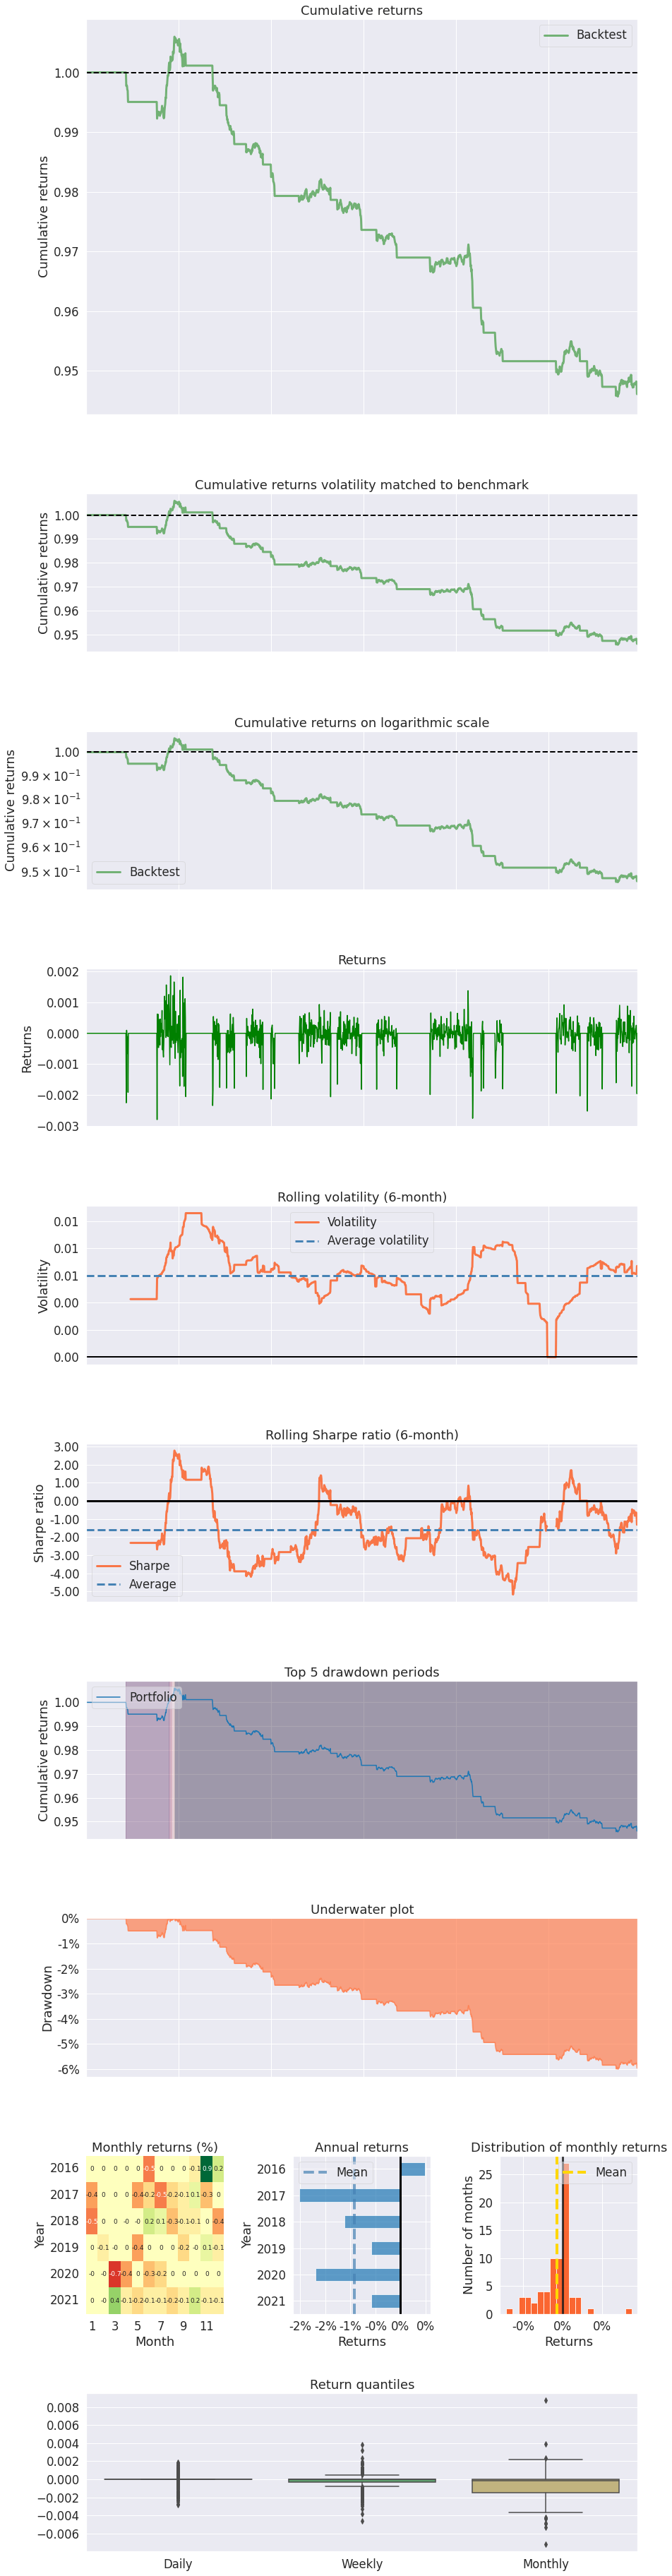

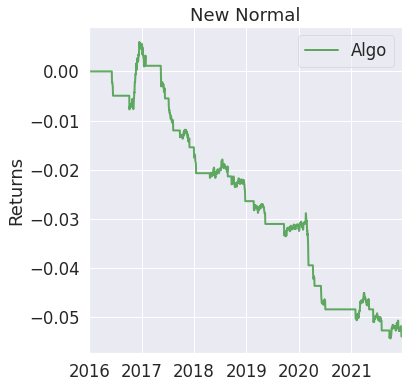

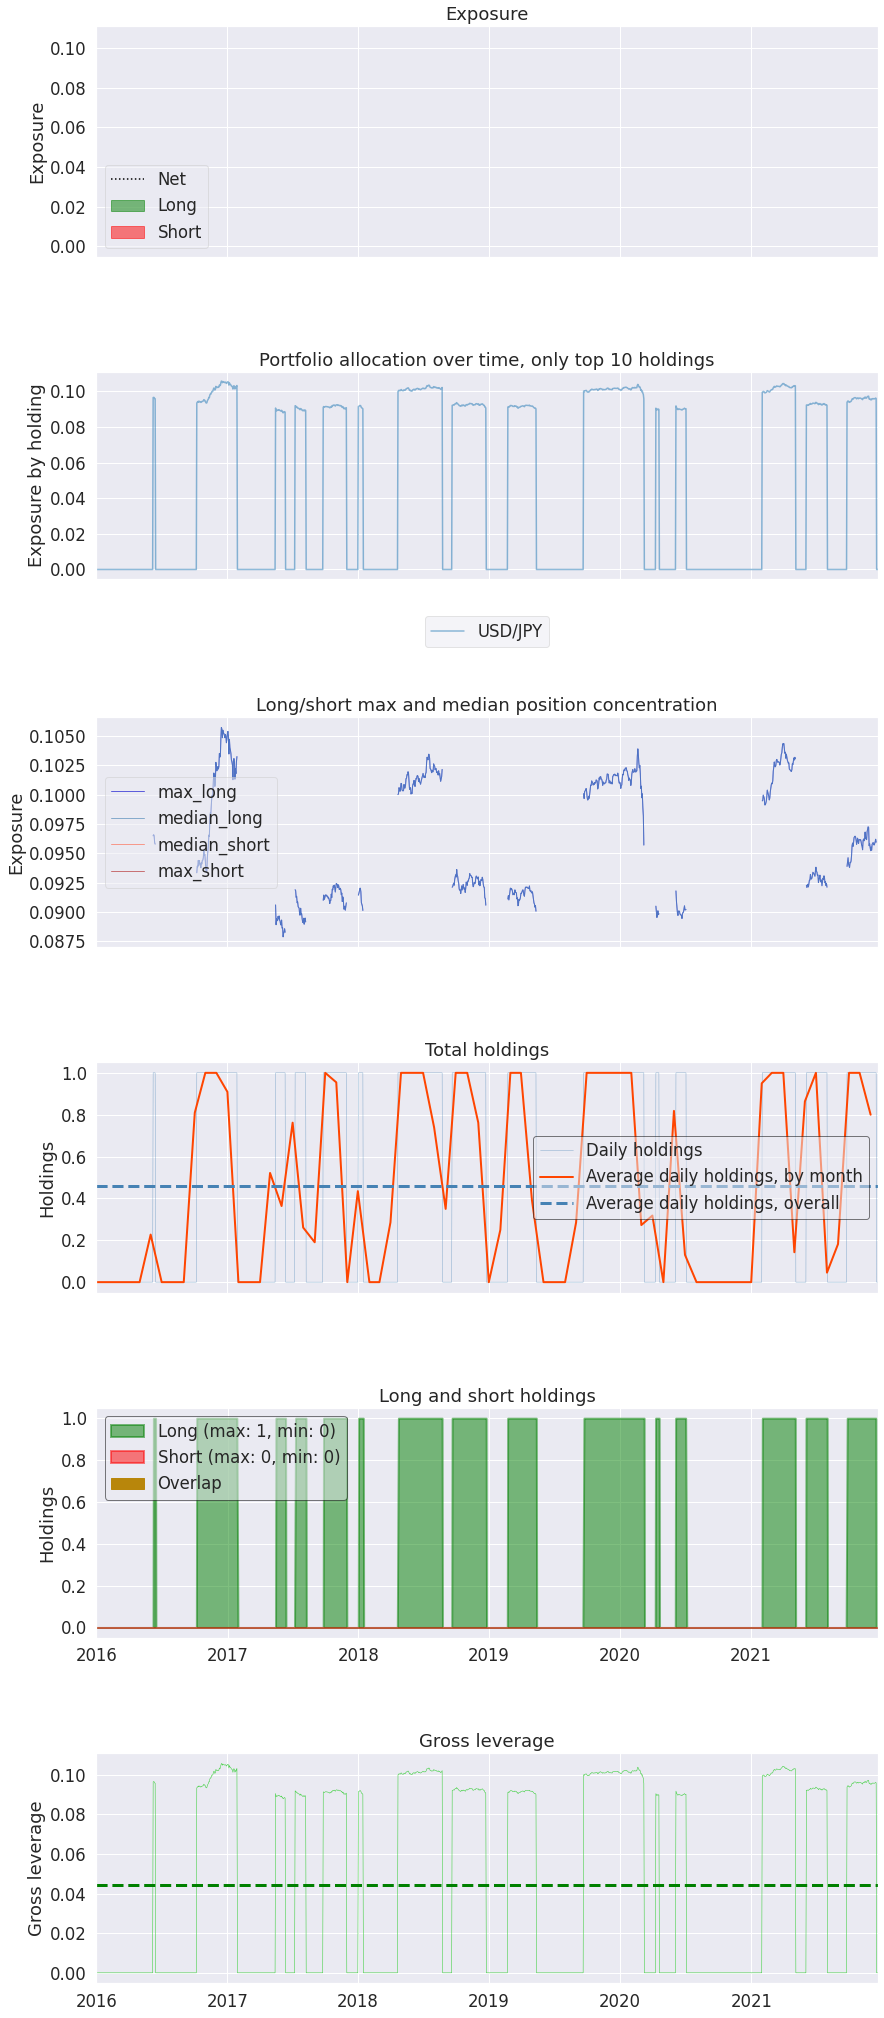

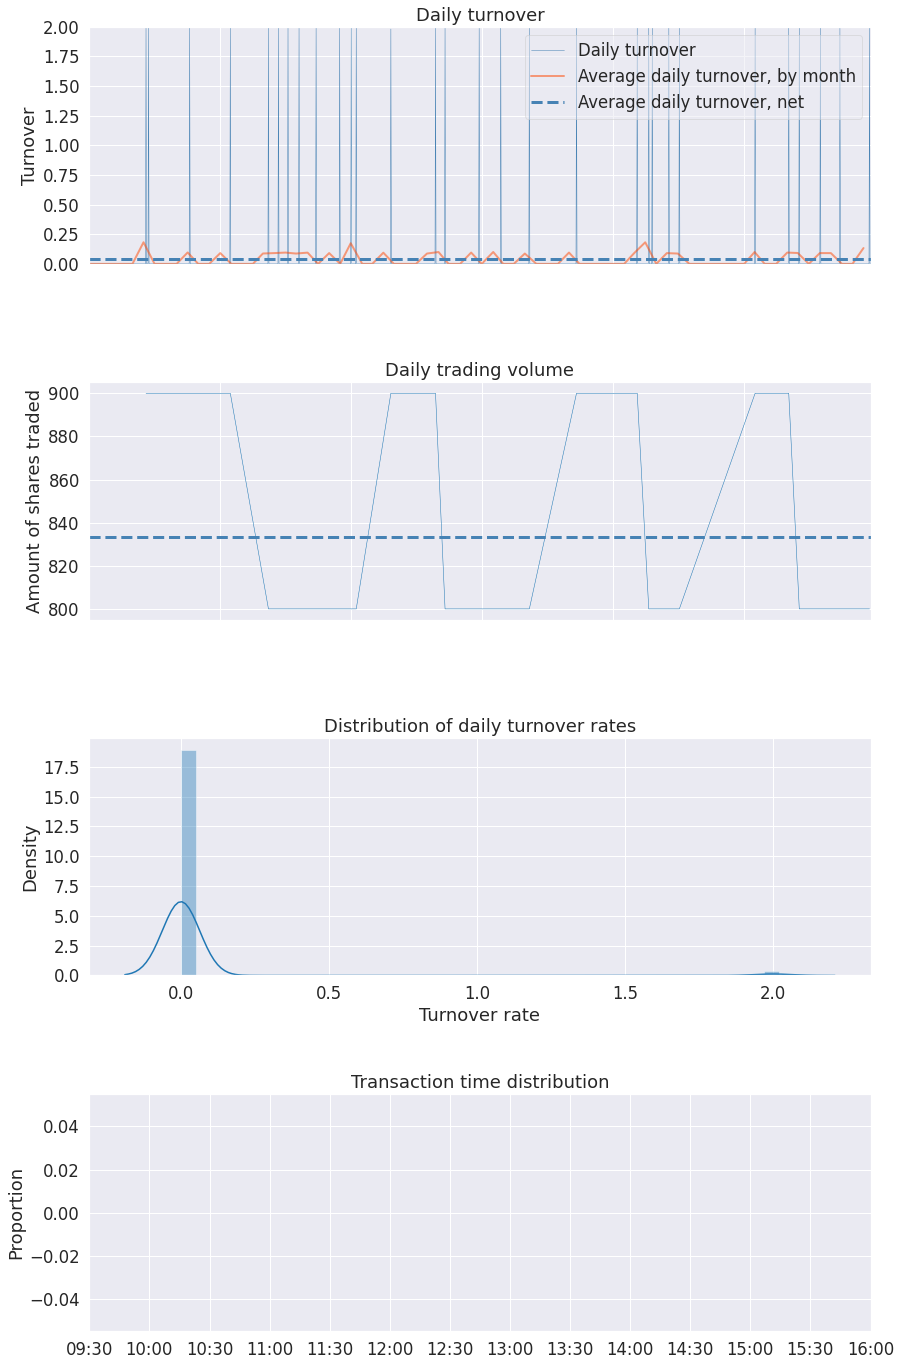

In [12]:
strat = stats[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
...
...
# pyfolio showtime
import pyfolio as pf

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions= transactions
   )